In [1]:
using Random
using Distributions
using LinearAlgebra
using SparseArrays
using BenchmarkTools
using Plots; pyplot();

In [2]:
zero_mean(x) = 0
squared_exponential_kernel(x, x′, l) = exp(-norm(x - x′)^2/l^2);

In [3]:
kernel_matrix(X, X′, k) = [k(x, x′) for x in X, x′ in X′];

In [4]:
function low_rank_kernel_matrix(Knn, Knm, Kmm)

    n, m = size(Knm)
    Λm, Umm = eigen(Kmm, sortby = x -> -abs(x))
    Λ̃ = n/m*Λm
    Ũ = sqrt(m/n)*Knm*Umm*diagm(1 ./ Λm)
    
    return Λ̃, Ũ

end;

In [5]:
function uniform_column_sampling_projection(n, m)
    
    S = spzeros(n, m)
    for (i, j) in zip(randperm(n)[1:m], 1:m)
        S[i, j] = 1
    end
    
    return S

end;

In [6]:
function l2_score_column_sampling_projection(n, m, A)
    
    S = spzeros(n, m)
    dist = DiscreteNonParametric(1:n, normalize!([norm(col)^2 for col in eachcol(A)], 1))
    list = []
    for i in 1:m
        while true
            it = rand(dist)
            if it ∉ list
                push!(list, it)
                S[it, i] = 1
                break
            end
        end
    end
    
    return S

end;

In [7]:
function inv_l2_score_column_sampling_projection(n, m, A)
    
    S = spzeros(n, m)
    dist = DiscreteNonParametric(1:n, normalize!([1/norm(col)^2 for col in eachcol(A)], 1))
    list = []
    for i in 1:m
        while true
            it = rand(dist)
            if it ∉ list
                push!(list, it)
                S[it, i] = 1
                break
            end
        end
    end
    
    return S

end;

## Simulation

In [8]:
X = rand(100)*20 .- 10
y = 1/3*log.(1 .+ abs.(X).^(2 .+ sin.(X))) .- 1 .+ randn(size(X))/12;
σ = 1E-4;
l = 2;
se_kernel_l(x, x′) = squared_exponential_kernel(x, x′, l);

K = kernel_matrix(X, X, se_kernel_l);

In [9]:
p = 30

#S = Array(uniform_column_sampling_projection(size(K)[2], p));
#S = Array(l2_score_column_sampling_projection(size(K)[2], p, K));
S = Array(inv_l2_score_column_sampling_projection(size(K)[2], p, K));

In [10]:
# generate eigenvalue decomposition of K and adjust to rank-p
# @btime eigen(K)
Λ, U = eigen(K); #Λ[p:end] .= 0
Klr = U*diagm(Λ)*U'

# generate eigenvalue decomposition of K̃ (rank-p)
# @btime low_rank_kernel_matrix(K, K*S, S'*K*S)
Λ̃, Ũ = low_rank_kernel_matrix(K, K*S, S'*K*S)
K̃lr = Ũ*diagm(Λ̃)*Ũ'

@show norm(K̃lr - K)
@show opnorm(K̃lr - K);

norm(K̃lr - K) = 1.0973739267301816e-5
opnorm(K̃lr - K) = 1.0736509824641493e-5


In [11]:
# invert kernel matrices in eigenvalue decomposition form using matrix inversion lemma
# @btime Kinv_slow = (K + σ*I)^-1
Kinv_slow = (K + σ*I)^-1
# @btime Kinv = 1/σ*(I - U*(σ*I + diagm(Λ)*U'*U)^-1*diagm(Λ)*U')
Kinv = 1/σ*(I - U*(σ*I + diagm(Λ)*U'*U)^-1*diagm(Λ)*U')
# @btime K̃inv = 1/σ*(I - Ũ*(σ*I + diagm(Λ̃)*Ũ'*Ũ)^-1*diagm(Λ̃)*Ũ')
K̃inv = 1/σ*(I - Ũ*(σ*I + diagm(Λ̃)*Ũ'*Ũ)^-1*diagm(Λ̃)*Ũ');

In [12]:
μ̂(x, X, y, Kinv) = kernel_matrix(x, X, se_kernel_l)'*Kinv*y
μ̃(x, X, y, K̃inv) = kernel_matrix(x, X, se_kernel_l)'*K̃inv*y
σ̂(x, X, Kinv)    = abs.(sqrt.(Complex.(kernel_matrix(x, x, se_kernel_l) .- kernel_matrix(x, X, se_kernel_l)'*Kinv*kernel_matrix(X, x, se_kernel_l))))
σ̃(x, X, K̃inv)    = abs.(sqrt.(Complex.(kernel_matrix(x, x, se_kernel_l) .- kernel_matrix(x, X, se_kernel_l)'*K̃inv*kernel_matrix(X, x, se_kernel_l))));

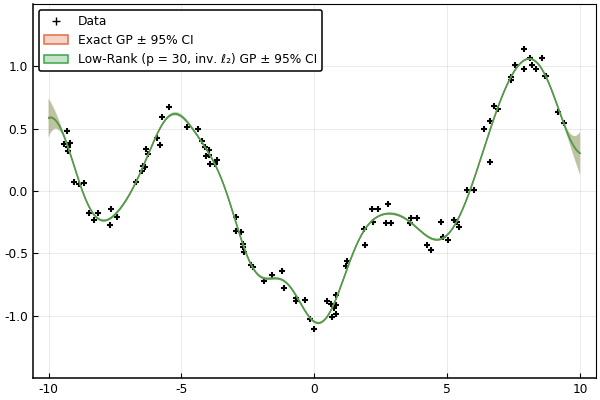

In [13]:
X_plot = -10:0.025:10
scatter(X, y, label="Data", marker=:+, mc=:black, msc=:auto, box=:on, thickness_scaling=1.1)
plot!(X_plot, [μ̂(x, X, y, Kinv) for x in X_plot], 
    ribbon=1.96*[σ̂(x, X, Kinv) for x in X_plot], 
    fillalpha=0.3, label="Exact GP ± 95% CI")
plot!(X_plot, [μ̃(x, X, y, K̃inv) for x in X_plot], 
    ribbon=1.96*[σ̃(x, X, K̃inv) for x in X_plot], 
    fillalpha=0.3, label="Low-Rank (p = $p, inv. ℓ₂) GP ± 95% CI")
ylims!(-1.5, 1.5)
#savefig("example_low_rank_gp_f_100_nonunif_p_$(p)_inv_l2_sampling.png")

In [14]:
using ProgressMeter
using Statistics
using StatsPlots;

ps = 1:100
max_t = 100

eigen_time = zeros(max_t)

for t in 1:max_t
    
    stats = @timed eigen(K)
    eigen_time[t] = stats.time
    
end

In [15]:
p_frob_err_sqr_means = []
p_frob_err_sqr_stds  = []
# p_spec_err_sqr_means = []
# p_spec_err_sqr_stds  = []
p_time_means         = []
p_time_stds          = []

p1 = plot(y_scale=:log10, box=:on, xlabel="Rank Approximation", ylabel="||K̃ - K||F²")
p2 = plot(y_scale=:log10, box=:on, xlabel="Rank Approximation", ylabel="Computation Time [sec]")

@showprogress for p in ps
    
    frob_err_sqrs = []
    spec_err_sqrs = []
    times         = []
    
    for t in 1:max_t
    
        S = Array(uniform_column_sampling_projection(size(K)[2], p));
        #S = Array(l2_score_column_sampling_projection(size(K)[2], p, K));
        #S = Array(inv_l2_score_column_sampling_projection(size(K)[2], p, K));

        # generate eigenvalue decomposition of K̃ (rank-p)
        stats = @timed Λ̃, Ũ = low_rank_kernel_matrix(K, K*S, S'*K*S)
        K̃lr = Ũ*diagm(Λ̃)*Ũ'

        frob_err_sqr = norm(K̃lr - K)^2
        (!isnan(frob_err_sqr) && !isinf(frob_err_sqr)) ? push!(frob_err_sqrs, frob_err_sqr) : nothing;
#         spec_err_sqr = opnorm(K̃lr - K)^2
#         (!isnan(spec_err_sqr) && !isinf(spec_err_sqr)) ? push!(spec_err_sqrs, spec_err_sqr) : nothing;
        push!(times, stats.time)
        
    end
    
    push!(p_frob_err_sqr_means, mean(frob_err_sqrs))
    push!(p_frob_err_sqr_stds,  std(frob_err_sqrs))
#     push!(p_spec_err_sqr_means, mean(spec_err_sqrs))
#     push!(p_spec_err_sqr_stds,  std(spec_err_sqrs))
    push!(p_time_means,         mean(times))
    push!(p_time_stds,          std(times))
    
    boxplot!(p1, p*ones(size(frob_err_sqrs)), frob_err_sqrs, α=0.4, color=:blue, 
        label=(p==1 ? "Frobenius Norm Error" : :none), outliers=false)
#     boxplot!(p1, p*ones(size(spec_err_sqrs)), spec_err_sqrs, α=0.4, color=:red,  
#         label=(p==1 ? "Spectral Norm Error" : :none), outliers=false)
    boxplot!(p2, p*ones(size(times)), times, α=0.4, color=:green,  
        label=(p==1 ? "Randomized Rank-p Approximation" : :none), outliers=false)
    
end

ylims!(p1, eps(Float64), 10^4)
annotate!(p1, xlims(p1)[1].+0.95*diff([xlims(p1)...]), 10^(0.95*log10(ylims(p1)[1]) + 0.05*log10(ylims(p1)[2])), 
                text("n = $max_t", :black, :right, 8))

ylims!(p2, 10^-5, 10^-2)
annotate!(p2, xlims(p2)[1].+0.95*diff([xlims(p2)...]), 10^(0.95*log10(ylims(p2)[1]) + 0.05*log10(ylims(p2)[2])), 
                text("n = $max_t", :black, :right, 8));
hline!(p2, [mean(eigen_time)], label="Exact Rank-p Approximation (100 data points)", w=1.5);

┌ Warning: Keyword argument hover not supported with Plots.PyPlotBackend().  Choose from: Set([:zforeground_color_guide, :top_margin, :group, :background_color, :stride, :yforeground_color_text, :yguidefontcolor, :seriesalpha, :legendfontcolor, :seriescolor, :ztick_direction, :zlims, :overwrite_figure, :normalize, :linestyle, :xflip, :yforeground_color_guide, :fillcolor, :ygrid, :background_color_inside, :bins, :yscale, :clims, :xtickfontcolor, :xguide, :fillalpha, :tick_direction, :yguidefontsize, :legendfontfamily, :foreground_color, :x, :legend, :discrete_values, :ytick_direction, :ribbon, :xdiscrete_values, :legendtitle, :xgridstyle, :orientation, :gridstyle, :markersize, :camera, :xforeground_color_grid, :quiver, :zticks, :markerstrokecolor, :xtickfontsize, :levels, :zgridstyle, :foreground_color_border, :marker_z, :markerstrokealpha, :markeralpha, :zguidefontcolor, :ygridlinewidth, :zlink, :zscale, :smooth, :xticks, :zguidefontsize, :y, :margin, :ytickfontcolor, :title_location, 

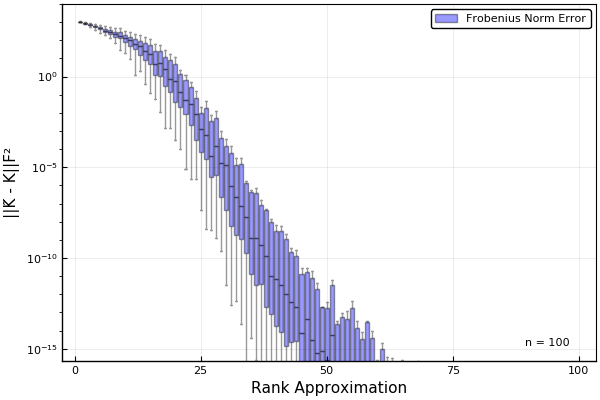

In [16]:
#savefig(p1, "f_100_nonunif_uniform_sampling_norm_error.png")
plot!(p1)

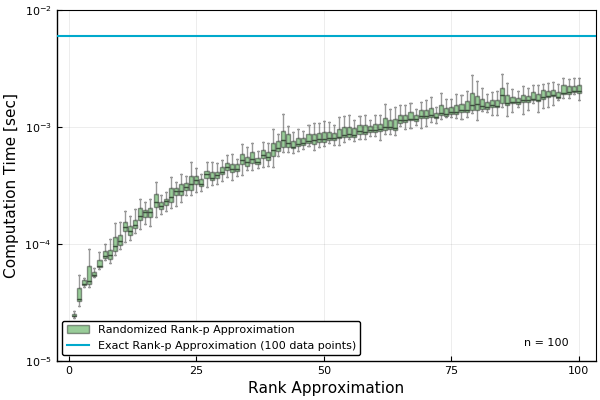

In [17]:
#savefig(p2, "f_100_nonunif_uniform_sampling_time.png")
plot!(p2)

In [18]:
n = size(X)[1]

function ℒ(l, σ) 
    
    return -n/2*log(π) - 
            1/2*log(det(kernel_matrix(X, X, (x, x′) -> squared_exponential_kernel(x, x′, l)) + σ*I)) - 
            1/2*y'*(kernel_matrix(X, X, (x, x′) -> squared_exponential_kernel(x, x′, l)) + σ*I)^-1*y
    
end

ls = 10 .^ (-1:0.025:0.7)
σs = 10 .^ (-3:0.025:-1)
ll = [ℒ(l, σ) for σ in σs, l in ls]
p3 = plot(box=:on)
contourf!(p3, ls, σs, ll, xscale=:log10, yscale=:log10, box=:on, xlabel="Length Scale, ℓ", ylabel="Noise, σ", 
    levels=50, color=:Spectral_r, clims=(-100, 100), title="Log-Likelihood of Data", thickness_scaling=1.1)
#savefig("log_likelihood_filled.png")

LoadError: MethodError: no method matching expand_extrema!(::Plots.Axis, ::RecipesPipeline.Surface{Array{Float64,2}})
Closest candidates are:
  expand_extrema!(::Plots.Axis, !Matched::Bool) at /Users/rossalexander/.julia/packages/Plots/cc8wh/src/axes.jl:337
  expand_extrema!(::Plots.Axis, !Matched::Nothing) at /Users/rossalexander/.julia/packages/Plots/cc8wh/src/axes.jl:336
  expand_extrema!(::Plots.Axis, !Matched::Plots.Surface) at /Users/rossalexander/.julia/packages/Plots/cc8wh/src/components.jl:670
  ...